In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config as cfg
import seaborn as sns
import ds_functions as ds

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from data import *
from strategies import randomForests

# Heart Failure Dataset

## Random Forests Raw

100%|██████████| 180/180 [00:23<00:00,  7.79it/s]


<Figure size 600x450 with 0 Axes>

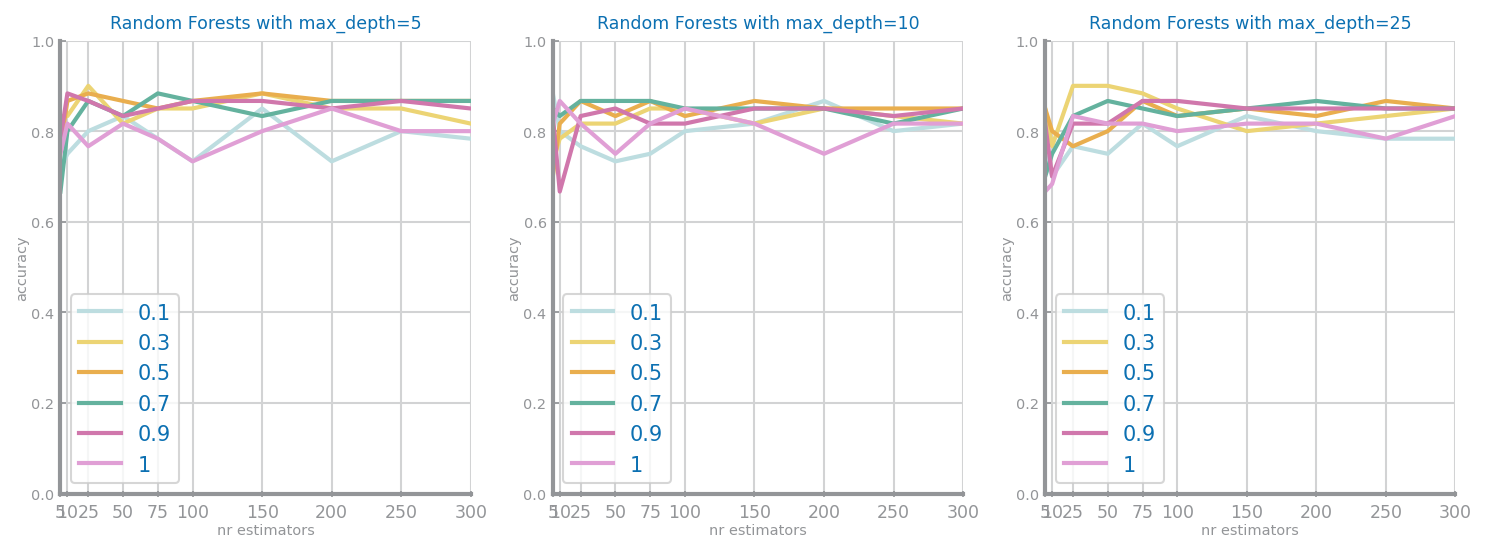

Best results with depth=5, 0.30 features and 25 estimators, with accuracy=0.9000


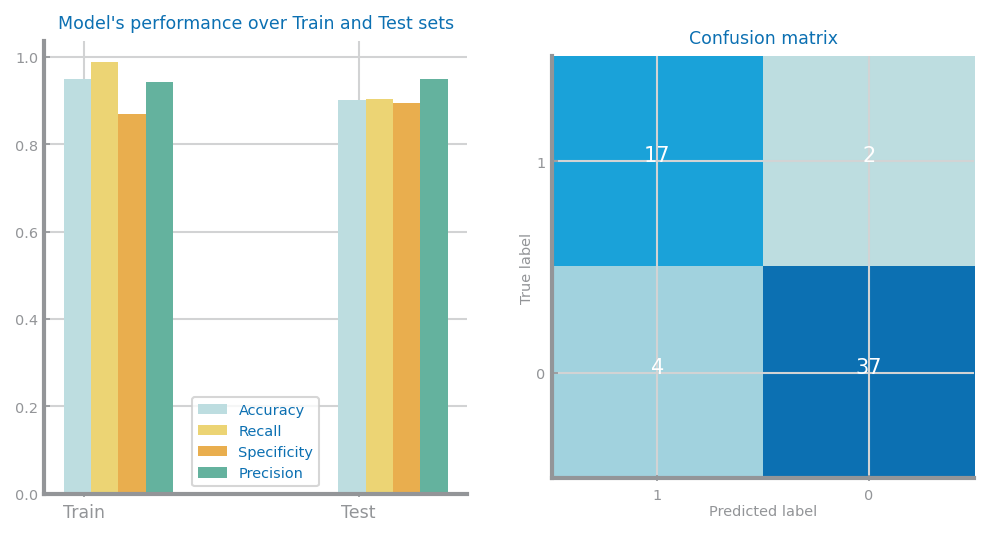

In [11]:
hf_data = get_hf_data(feature_selection=False, filter_outliers=False)
opts = randomForests(hf_data, 'DEATH_EVENT', kfold=True, quick=False, balancing=None)

## Random Forests Feature Selection

100%|██████████| 180/180 [00:24<00:00,  7.46it/s]


<Figure size 600x450 with 0 Axes>

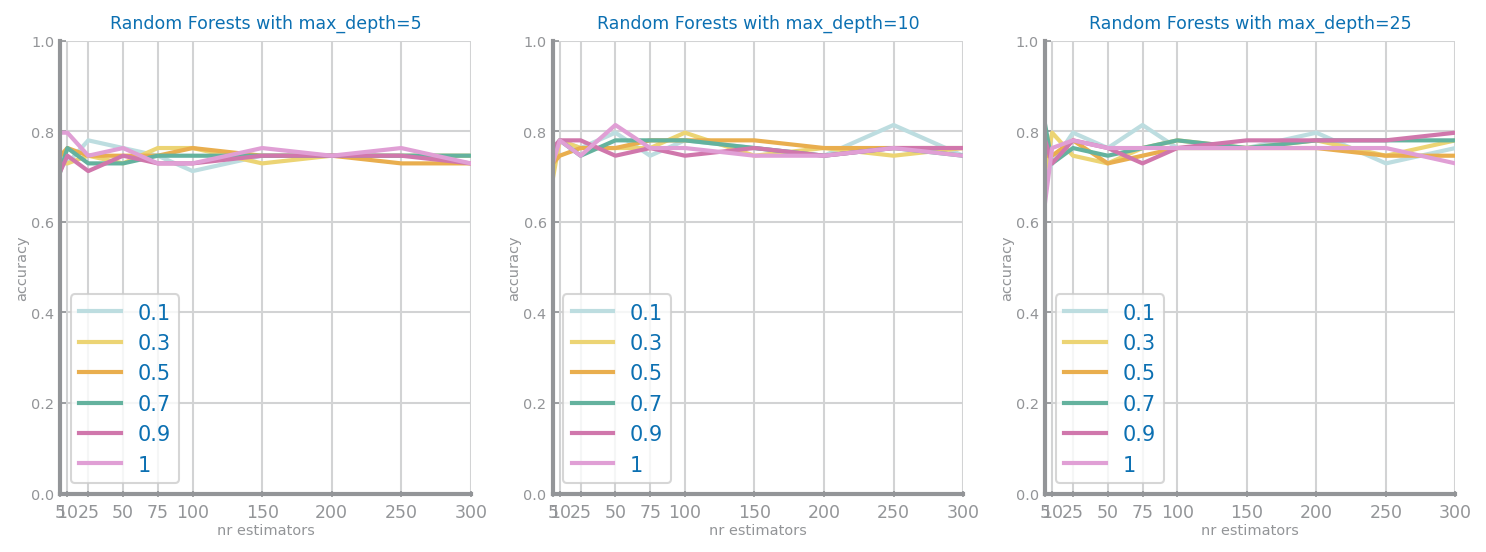

Best results with depth=10, 0.10 features and 250 estimators, with accuracy=0.8136


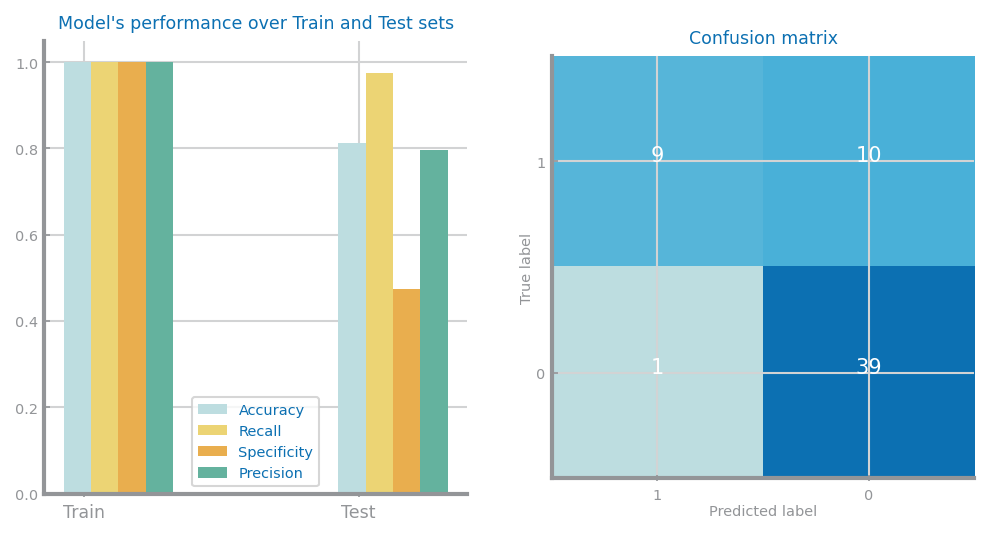

In [14]:
hf_data = get_hf_data(feature_selection=True, filter_outliers=False)
opts = randomForests(hf_data, 'DEATH_EVENT', kfold=True, quick=False, balancing=None)

## Random Forests Outliers

100%|██████████| 180/180 [00:23<00:00,  7.53it/s]


<Figure size 600x450 with 0 Axes>

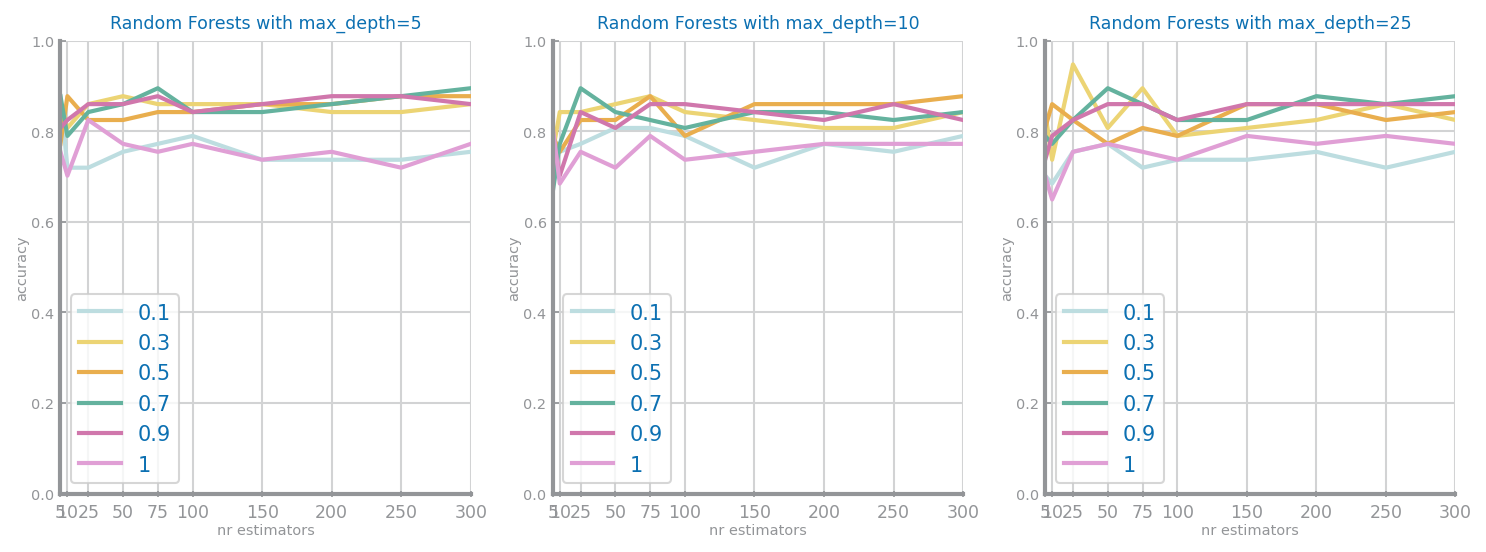

Best results with depth=25, 0.30 features and 25 estimators, with accuracy=0.9474


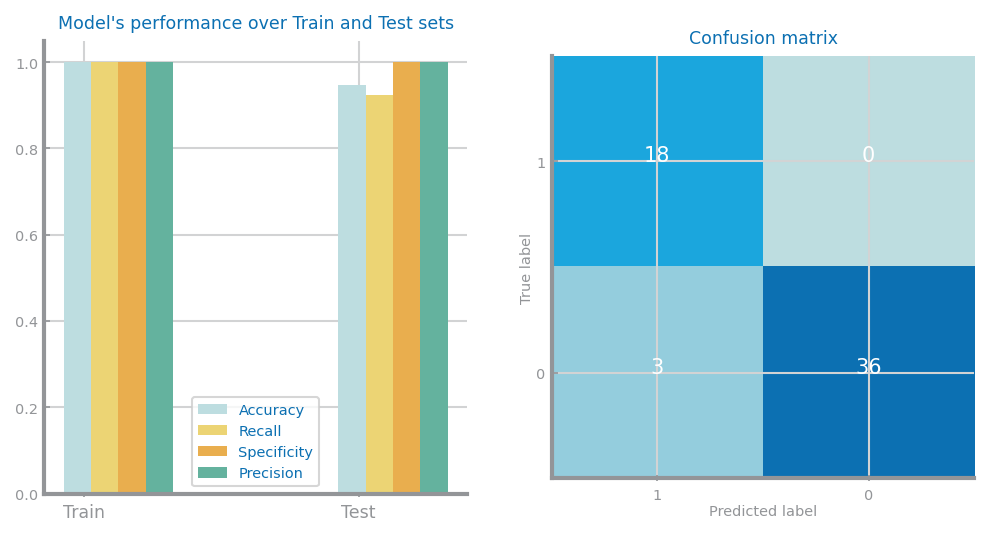

In [13]:
hf_data = get_hf_data(feature_selection=False, filter_outliers=True)
opts = randomForests(hf_data, 'DEATH_EVENT', kfold=True, quick=False, balancing=None)

## Random Forests Outliers balacnings (so o melhor)

100%|██████████| 180/180 [00:21<00:00,  8.30it/s]


<Figure size 600x450 with 0 Axes>

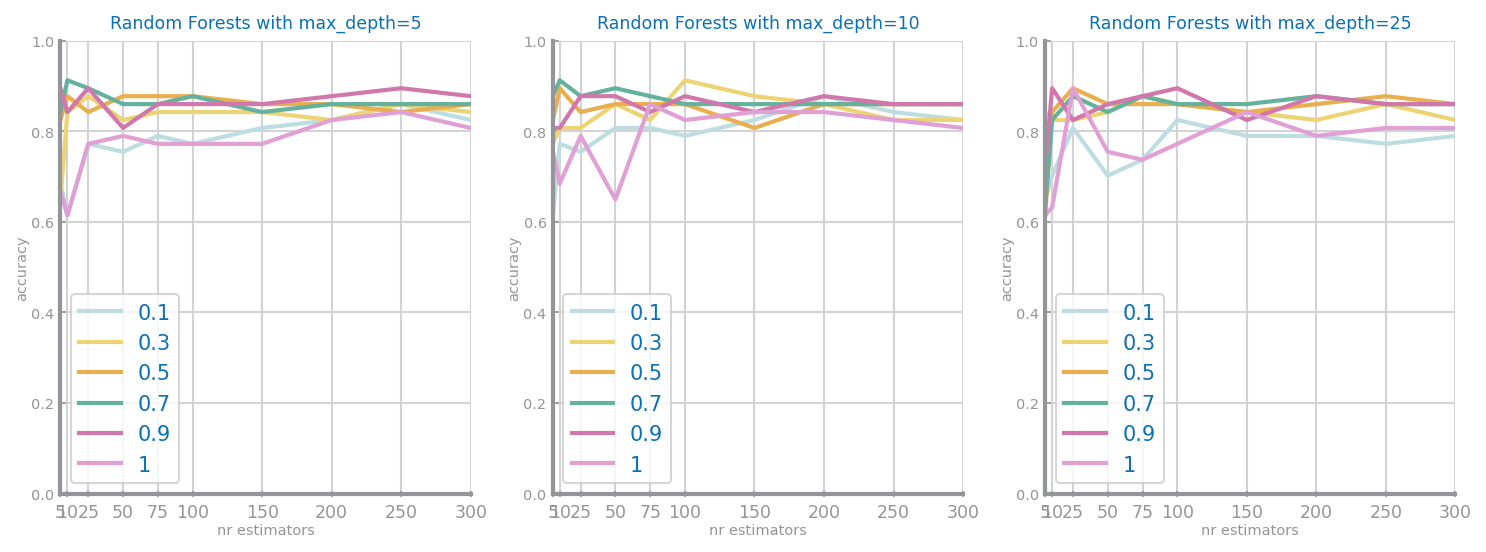

Best results with depth=5, 0.70 features and 10 estimators, with accuracy=0.9123


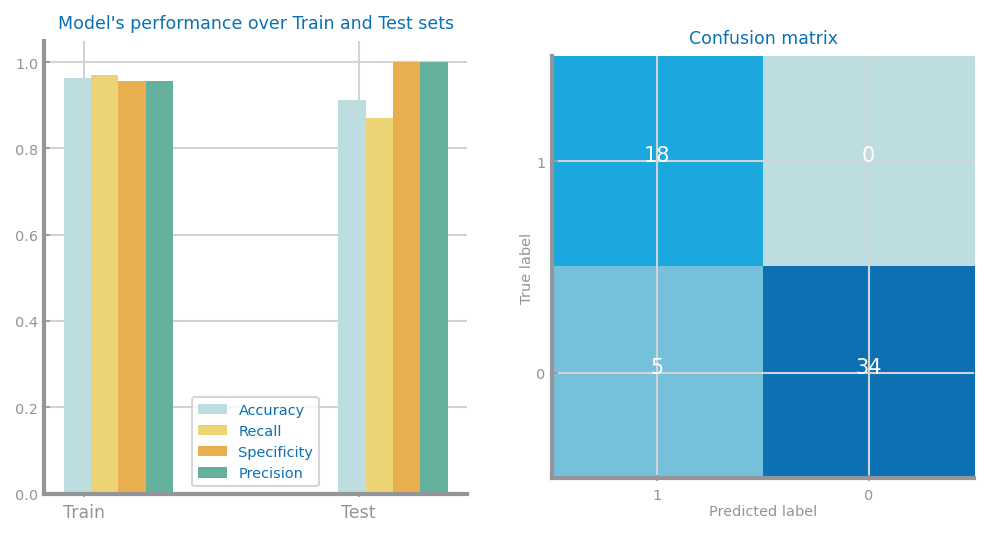

In [19]:
hf_data = get_hf_data(feature_selection=False, filter_outliers=True)
opts = randomForests(hf_data, 'DEATH_EVENT', kfold=True, quick=False, balancing='undersample')

In [ ]:
from sklearn.tree import export_graphviz
from subprocess import call

fig, axs = plt.subplots(len(best_tree.estimators_), 1, figsize=(16, 18), squeeze=False)
i = 0
for tree_in_forest in best_tree.estimators_:
    dot_data = export_graphviz(tree_in_forest,
                feature_names=hf_df.columns,
                filled=True,
                rounded=True,
                out_file='dtree.dot')
    # Convert to png
    call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=600'])

    axs[i, 0].imshow(plt.imread('dtree.png'))
    axs[i, 0].axis('off')
    
    i += 1
plt.show()

# Toxicity Dataset

## Random Forests oversample

100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


<Figure size 600x450 with 0 Axes>

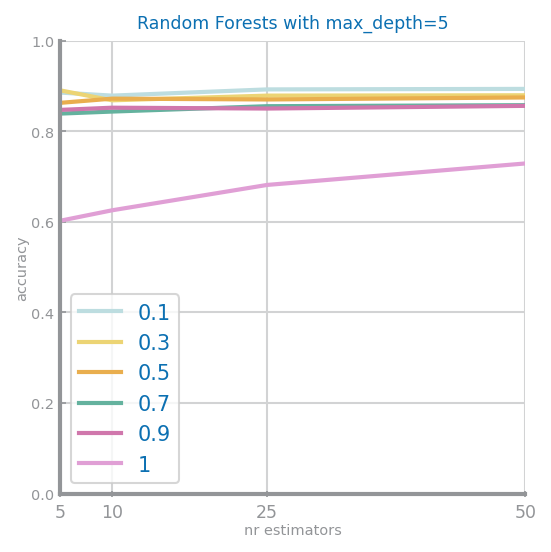

Best results with depth=5, 0.10 features and 50 estimators, with accuracy=0.8933


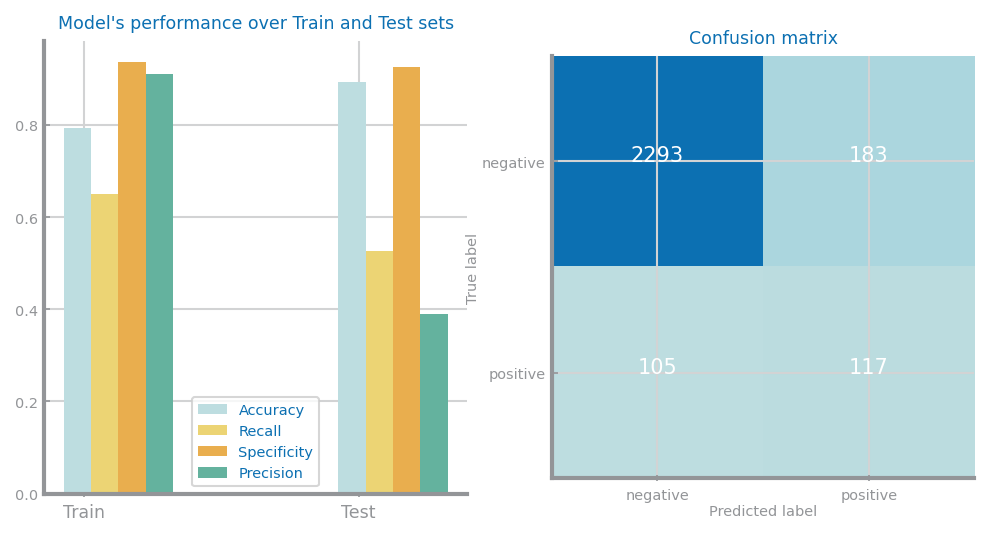

In [2]:
t_data = get_t_data(feature_selection=0)
opts = randomForests(t_data, 'toxic', kfold=False, quick=True, balancing='oversample')

## Random Forests oversample feature selection

100%|██████████| 24/24 [00:41<00:00,  1.73s/it]


<Figure size 600x450 with 0 Axes>

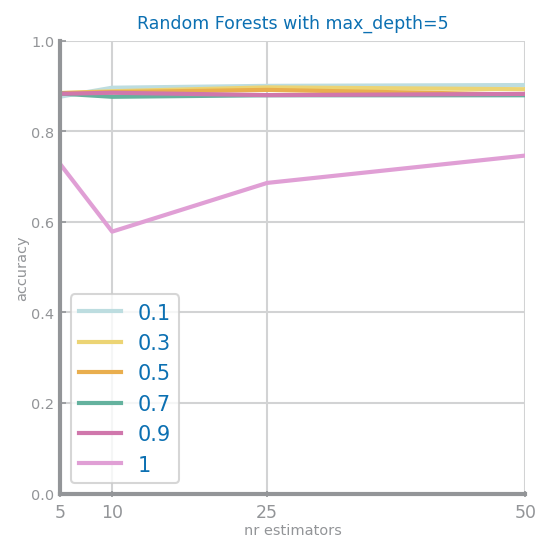

Best results with depth=5, 0.10 features and 50 estimators, with accuracy=0.9018


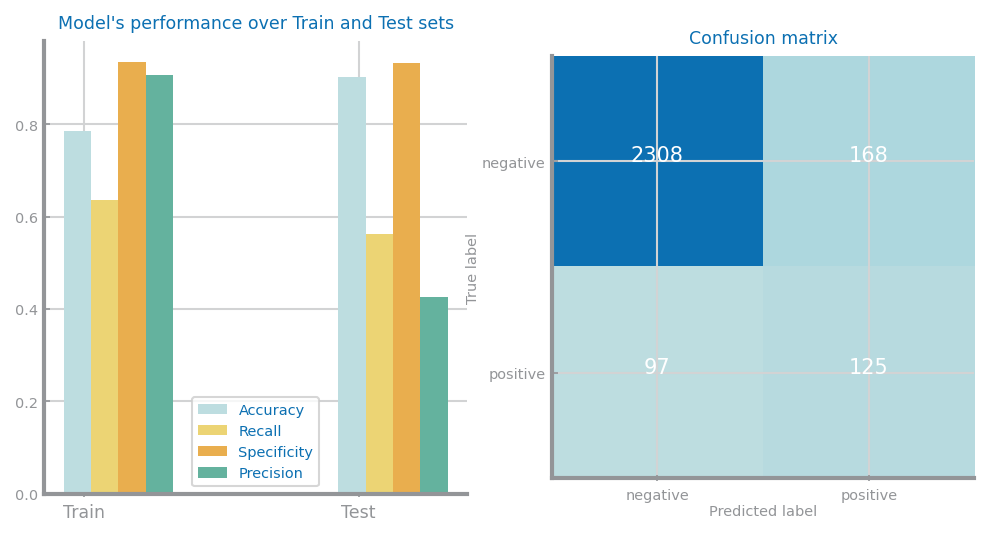

In [3]:
t_data = get_t_data(feature_selection=0.85)
opts = randomForests(t_data, 'toxic', kfold=False, quick=True, balancing='oversample')

## Random Forests SMOTE feature selection

100%|██████████| 24/24 [00:50<00:00,  2.09s/it]


<Figure size 600x450 with 0 Axes>

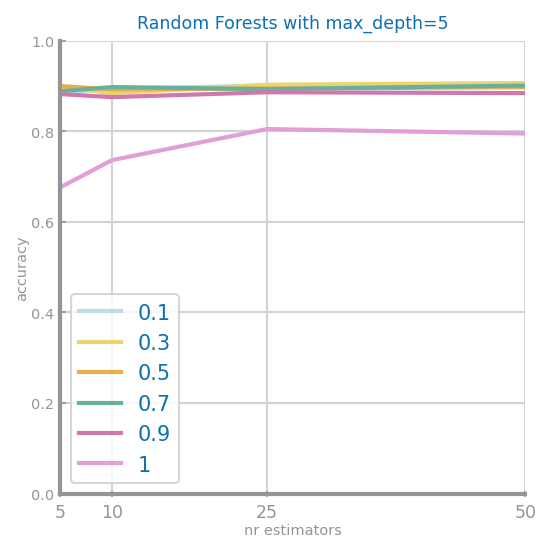

Best results with depth=5, 0.30 features and 50 estimators, with accuracy=0.9062


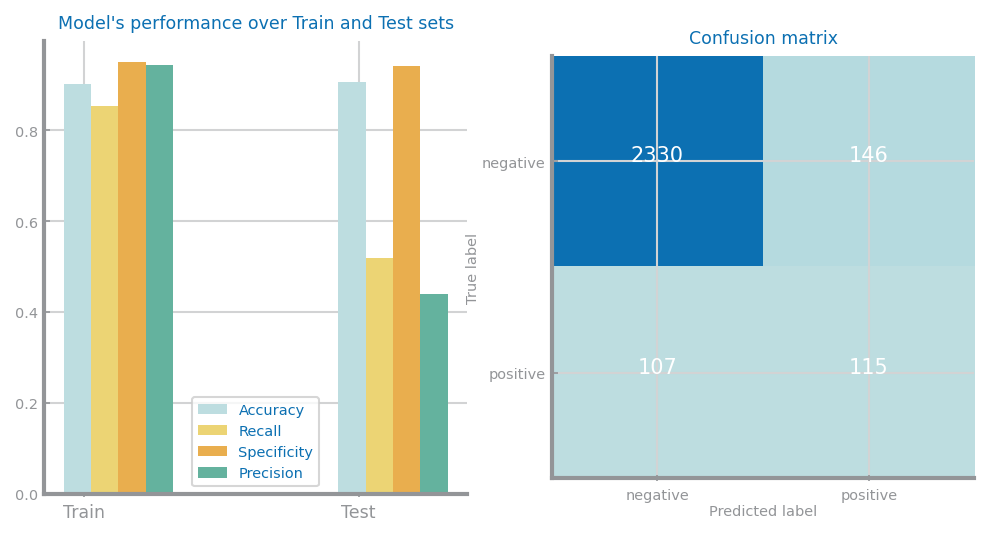

In [5]:
t_data = get_t_data(feature_selection=0.85)
opts = randomForests(t_data, 'toxic', kfold=False, quick=True, balancing='smote')

## Random Forests no balacing feature selection

100%|██████████| 24/24 [00:34<00:00,  1.43s/it]


<Figure size 600x450 with 0 Axes>

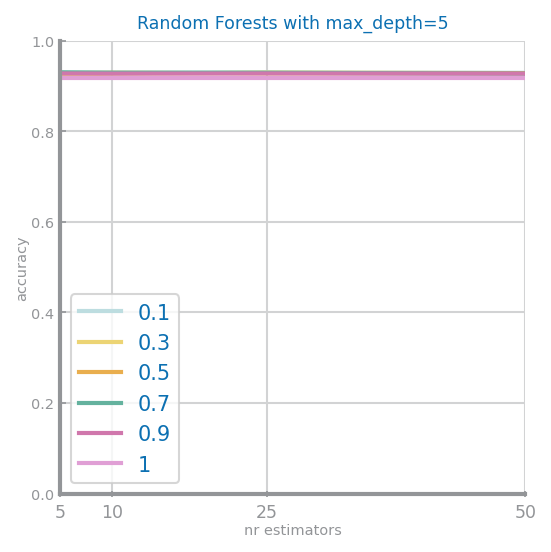

Best results with depth=5, 0.10 features and 25 estimators, with accuracy=0.9299


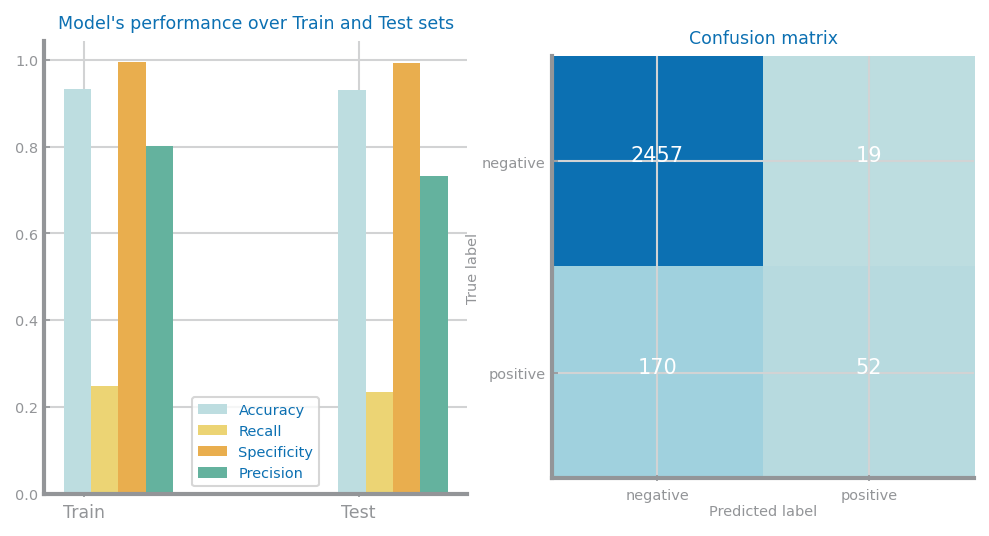

In [6]:
t_data = get_t_data(feature_selection=0.85)
opts = randomForests(t_data, 'toxic', kfold=False, quick=True, balancing=None)

## Random Forests raw

100%|██████████| 24/24 [00:41<00:00,  1.74s/it]


<Figure size 600x450 with 0 Axes>

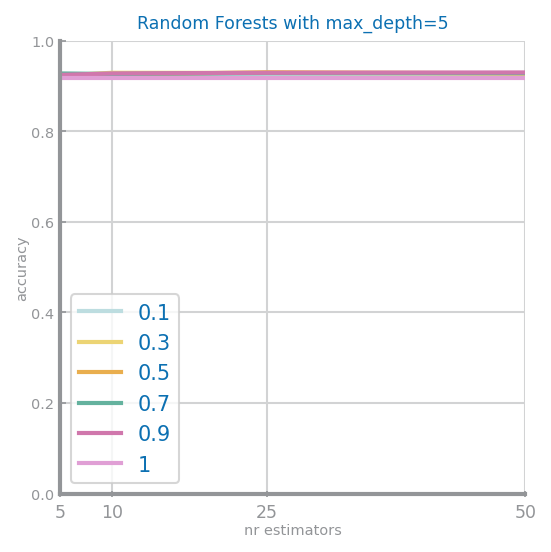

Best results with depth=5, 0.50 features and 25 estimators, with accuracy=0.9299


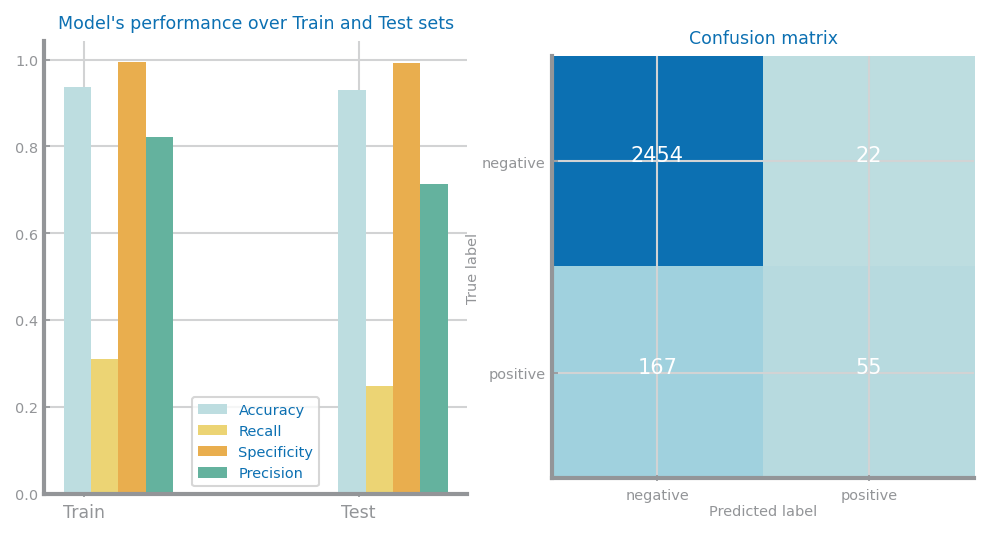

In [7]:
t_data = get_t_data(feature_selection=0)
opts = randomForests(t_data, 'toxic', kfold=False, quick=True, balancing=None)